Tried different ways to remove background

Decided to do it simple way since all the photos have had white-ish background and all the other methods didn't work so well in my hands

In [1]:
import pgmagick as pg

def trans_mask_sobel(img):
    """ Generate a transparency mask for a given image """

    image = pg.Image(img)

    # Find object
    image.negate()
    image.edge()
    image.blur(1)
    image.threshold(24)
    image.adaptiveThreshold(5, 5, 5)

    # Fill background
    image.fillColor('magenta')
    w, h = image.size().width(), image.size().height()
    image.floodFillColor('0x0', 'magenta')
    image.floodFillColor('0x0+%s+0' % (w-1), 'magenta')
    image.floodFillColor('0x0+0+%s' % (h-1), 'magenta')
    image.floodFillColor('0x0+%s+%s' % (w-1, h-1), 'magenta')

    image.transparent('magenta')
    return image

def alpha_composite(image, mask):
    """ Composite two images together by overriding one opacity channel """

    compos = pg.Image(mask)
    compos.composite(
        image,
        image.size(),
        pg.CompositeOperator.CopyOpacityCompositeOp
    )
    return compos

def remove_background(filename):
    """ Remove the background of the image in 'filename' """

    img = pg.Image(filename)
    transmask = trans_mask_sobel(img)
    img = alpha_composite(transmask, img)
    img.trim()
    img.write('out.png')

In [2]:
remove_background('./pics/tsm_2277074.jpg')
"""results in out.png"""

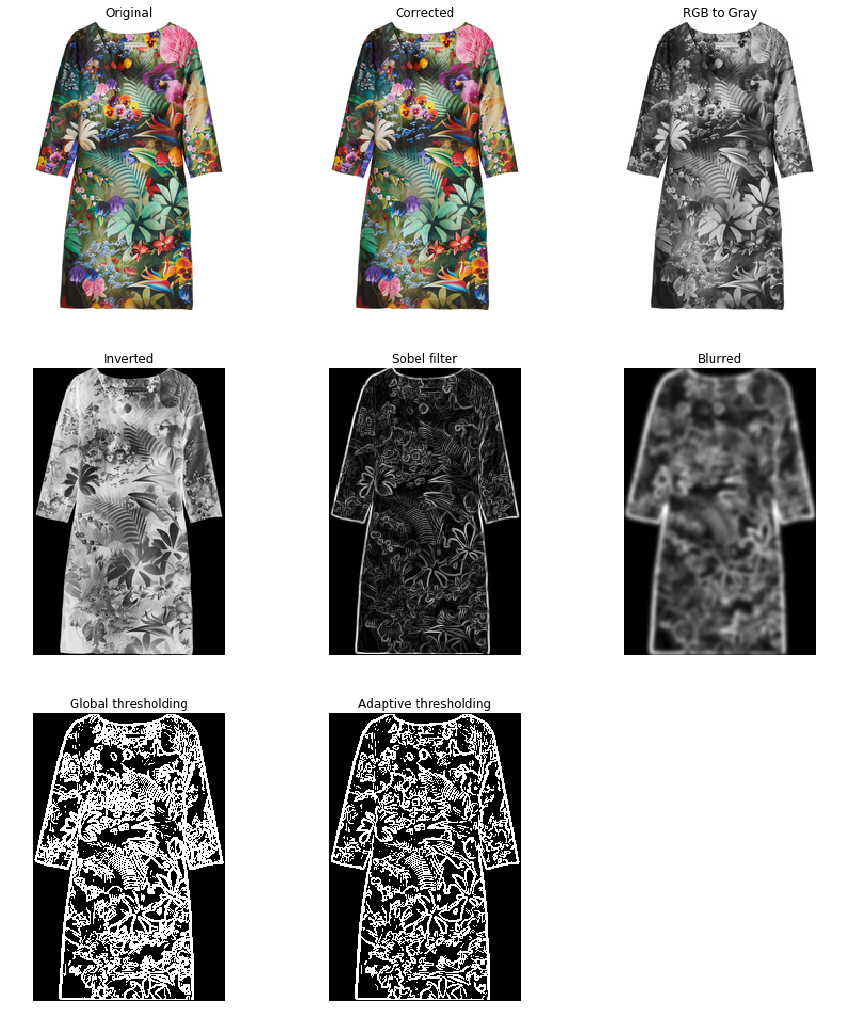

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io
from skimage.util import invert
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_local, sobel, gaussian

filename = './pics/nap_937889.jpg'

image = io.imread(filename)
img = image

w, h, c = image.shape
r, g, b, wht = image[:,:,0], image[:,:,1], image[:,:,2], 250
mask = (r>=wht) & (g>=wht) & (b>=wht)

img[mask] = [255,255,255]

gray = rgb2gray(img[:,:,:3])
invert = invert(gray)
sobel = sobel(invert)
blur = gaussian(sobel, sigma=2.)

global_thresh = threshold_otsu(blur)
binary_global = sobel > global_thresh

block_size = 35
adaptive_thresh = threshold_local(blur, block_size)
binary_adaptive = sobel > adaptive_thresh

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 18))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(img)
ax[1].set_title('Corrected')

ax[2].imshow(gray)
ax[2].set_title('RGB to Gray')

ax[3].imshow(invert)
ax[3].set_title('Inverted')

ax[4].imshow(sobel)
ax[4].set_title('Sobel filter')

ax[5].imshow(blur)
ax[5].set_title('Blurred')

ax[6].imshow(binary_global)
ax[6].set_title('Global thresholding')

ax[7].imshow(binary_adaptive)
ax[7].set_title('Adaptive thresholding')

for a in ax:
    a.axis('off')

plt.show()

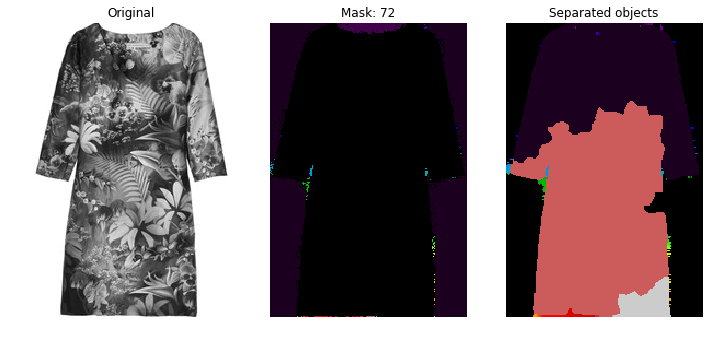

In [4]:
%matplotlib inline

from scipy import ndimage as ndi
from skimage import io, exposure
from skimage.morphology import watershed
from skimage.feature import peak_local_max

img = io.imread(filename)
w, h, c = img.shape
r, g, b, wht, blk = img[:,:,0], img[:,:,1], img[:,:,2], 250, 5

bool_mask = np.zeros(img.shape[:2], dtype=np.bool)

mask = (r>=wht) & (g>=wht) & (b>=wht)
img[mask] = [255,255,255]

bool_mask[mask] = True

seed_mask, num_seeds = ndi.label(bool_mask)

seed_mask[seed_mask==seed_mask[w-1,0]]=seed_mask[0,0]
seed_mask[seed_mask==seed_mask[0,h-1]]=seed_mask[0,0]
seed_mask[seed_mask==seed_mask[w-1,h-1]]=seed_mask[0,0]

#seed_mask = np.zeros(img.shape[:2], dtype=np.int)
#seed_mask[0, 0] = 1 # background
#seed_mask[w-1, h-1] = 1 # background
#seed_mask[135, 83] = 2 # foreground

#labels = watershed(blur, markers)
#distance = ndi.distance_transform_edt(gray)

#local_maxi = peak_local_max(gray, indices=False, min_distance=5)
#seed_mask, num_seeds = ndi.label(local_maxi)
#seed_mask[seed_mask>0] = 1

labels = watershed(blur, seed_mask)

fig, axes = plt.subplots(ncols=3, figsize=(10, 18))
ax = axes.ravel()

ax[0].imshow(gray)
ax[0].set_title('Original')

ax[1].imshow(seed_mask, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Mask: ' + str(num_seeds))

ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax: a.set_axis_off()

fig.tight_layout()
plt.show()

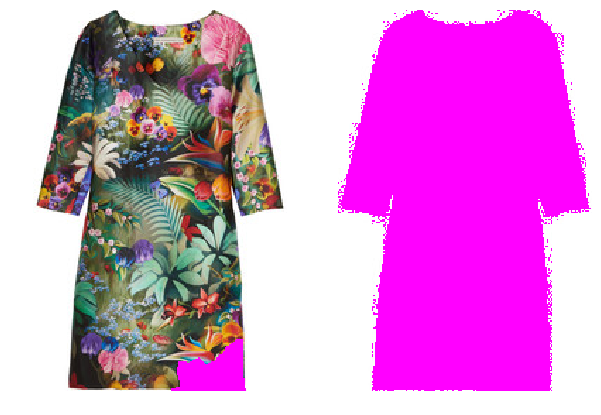

103573


In [5]:
nim = io.imread(filename)
mask = labels == np.max(labels)
nim[mask] = [255,0,255]

wim = io.imread(filename)
mask = (r>=wht) & (g>=wht) & (b>=wht)
wim[~mask] = [255,0,255]

fig, axes = plt.subplots(ncols=2, figsize=(10, 18))
ax = axes.ravel()

ax[0].imshow(nim)
ax[1].imshow(wim)

for a in ax: a.set_axis_off()

plt.show()

print (np.sum(wim!=nim))